In [4]:
!pip install catboost skimpy

Importing Libraries
   - Libraries such as `pandas` are used for data handling, `warnings` to suppress warnings, and `missingno` for missing data visualization. Libraries like `skimpy`, `itertools`, and `catboost` are imported for further use.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning
from itertools import combinations
from catboost import CatBoostClassifier
from skimpy import skim

warnings.filterwarnings('ignore')


- Missing Value Check: Based on the output of `data.isna().sum()`, it appears that all columns have zero missing values. This indicates that the dataset is complete, and no further imputation is needed.
- Initial Data Display: The `data.head()` gives an overview of the data structure and types, which is useful for beginning exploratory data analysis.


In [6]:
# Load the dataset
data = pd.read_csv("ad_10000records.csv", low_memory=False)  # Optimize loading
data.head()

print(data.isna().sum())
print('\n')

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Gender                      0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64




Basic Statistics and Initial Data Structure:
   - The `data.info()` function provides a summary of the dataset, including the number of entries (10,000), non-null counts, and data types for each column.
   - The dataset includes 10 columns: 'Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Ad Topic Line', 'City', 'Gender', 'Country', 'Timestamp', and 'Clicked on Ad'.

Check Unique Values:
   - The code calculates the total number of 'Ad Topic Line' entries using `len(data['Ad Topic Line'])`.
   - It also checks the unique number of 'Ad Topic Line' entries using `len(data['Ad Topic Line'].unique())`.
   - The output shows 10,000 total 'Ad Topic Lines' but only 559 unique entries, indicating that many ad topics are repeated throughout the dataset.

3. Descriptive Statistics:
   - The descriptive statistics (`data.describe()`) show key statistics for each numerical column:
     - 'Daily Time Spent on Site': Mean value is 61.67 minutes, with a standard deviation of 15.74 minutes.
     - 'Age': Mean value is 35.94 years, indicating an average user age around mid-30s.
     - 'Area Income': The average income is 53,840, with a noticeable range of values.
     - 'Clicked on Ad': This binary column indicates whether an ad was clicked (0 or 1).

4. Visualizing Missing Data:
   - Using `missingno.matrix(data)`, the visualization shows that there are no missing values across the dataset since all columns are fully shaded, indicating completeness.


Basic Statistics:
       Daily Time Spent on Site           Age   Area Income  \
count              10000.000000  10000.000000  10000.000000   
mean                  61.660757     35.940100  53840.047721   
std                   15.704142      8.572973  13343.708718   
min                   32.600000     19.000000  13996.500000   
25%                   48.860000     29.000000  44052.302500   
50%                   59.590000     35.000000  56180.930000   
75%                   76.580000     42.000000  61840.260000   
max                   90.970000     60.000000  79332.330000   

       Daily Internet Usage  Clicked on Ad  
count          10000.000000   10000.000000  
mean             177.759831       0.491700  
std               40.820951       0.499956  
min              105.220000       0.000000  
25%              140.150000       0.000000  
50%              178.920000       0.000000  
75%              212.670000       1.000000  
max              269.960000       1.000000  
<class '

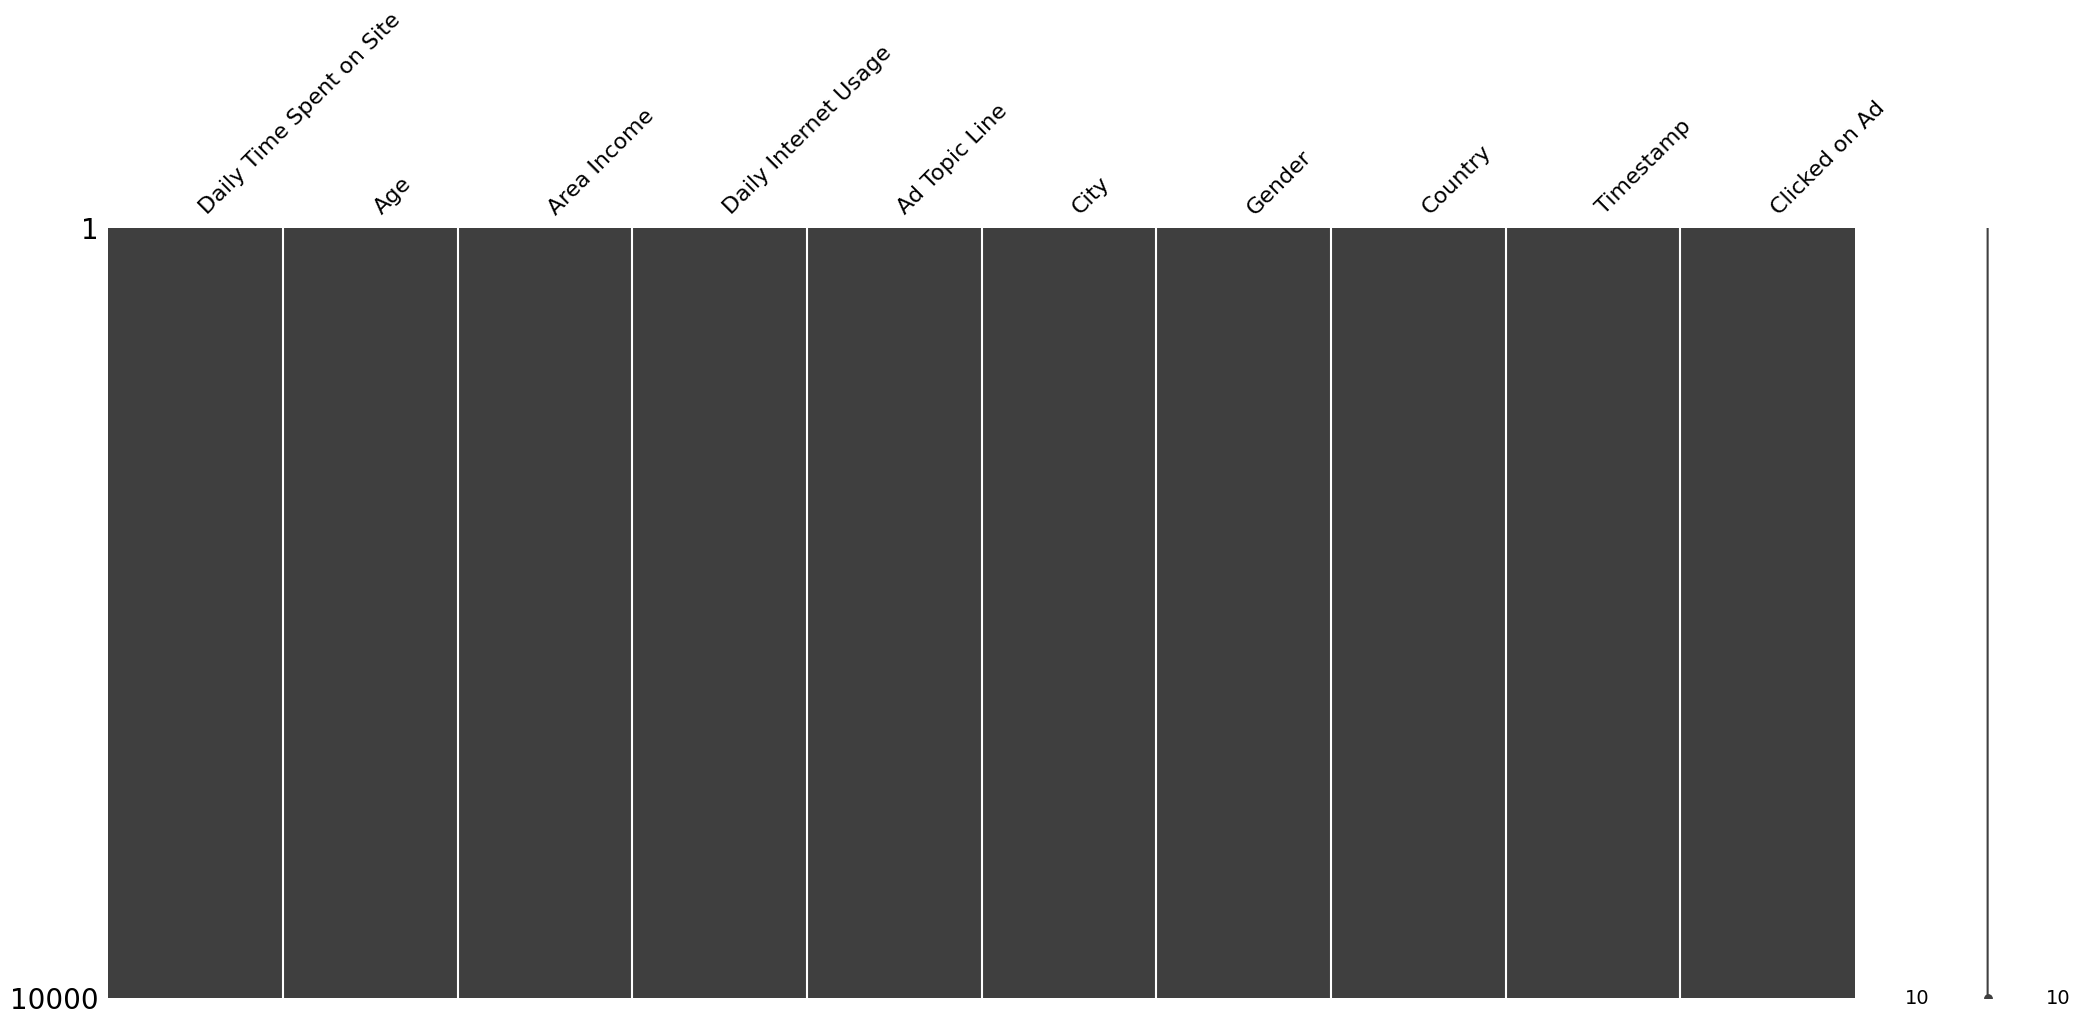

In [7]:
# Check for missing data using missingno
missingno.matrix(data)

# Replace infinite values with NaN
data = data.replace([np.inf, -np.inf], np.nan)

# Basic Statistics
print("\nBasic Statistics:")
print(data.describe())

# Basic statistics and initial data structure
data.info()

# Check unique values
print(f"\nTotal Ad Topic Lines: {len(data['Ad Topic Line'])}")
print(f"Unique Ad Topic Lines: {len(data['Ad Topic Line'].unique())}")



1. Change Column Data Types for Categorical Features:
   - The code converts several columns (`"City"`, `"Gender"`, `"Country"`, `"Clicked on Ad"`, `"Ad Topic Line"`) to categorical type using `.astype("category")`.
   - Rationale: Converting these columns to categorical types reduces memory usage and ensures that the categorical variables are efficiently stored and processed during modeling.
2. Convert `Timestamp` to DateTime Format:
   - The column `'Timestamp'` is converted to a datetime format using `pd.to_datetime(data['Timestamp'])`.
   - Rationale: This conversion allows the extraction of useful time-related features such as month, day, and hour, which can improve model accuracy by capturing temporal trends.
3. Extract Date-Related Features:
   - The code extracts the month, day, and hour from the `'Timestamp'` and stores them in new columns (`'month'`, `'day'`, `'hour'`).
   - Rationale: Extracting these features can help the model understand seasonality or time-dependent patterns that may affect user behavior, such as clicking on ads at specific hours or days.
4. Change Data Types of Extracted Features to Categorical:
   - The newly extracted features (`'month'`, `'day'`, `'hour'`) are also converted to categorical types.
   - Rationale: This helps the model treat these features as discrete categories rather than continuous values, which can improve performance when fitting classification models.
   5. Encode Categorical Features Using `LabelEncoder`:
   - A `LabelEncoder` is used to encode categorical features, converting them into numerical values.
   - Rationale: Machine learning models work with numerical data, so it is necessary to encode categorical variables into numerical form. `LabelEncoder` is a straightforward approach for label encoding, suitable for categorical features with a limited number of unique values.

In [8]:
# Change column data types for categorical features
for each_column in ["City", "Gender", "Country", "Clicked on Ad", "Ad Topic Line"]:
    data[each_column] = data[each_column].astype("category")

data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Extract date-related features
data['month'] = data['Timestamp'].dt.month
data['day'] = data['Timestamp'].dt.day
data['hour'] = data['Timestamp'].dt.hour
data.info()

# Change data types of extracted features to category
for each_column in ["month", "day", "hour"]:
    data[each_column] = data[each_column].astype("category")

data.info()

# Encode categorical features using LabelEncoder
label_encoders = {}
for cat_col in ["City", "Gender", "Country", "Ad Topic Line", "Clicked on Ad", "month", "day", "hour"]:
    label_encoders[cat_col] = LabelEncoder()
    data[cat_col] = label_encoders[cat_col].fit_transform(data[cat_col])
    data[cat_col] = data[cat_col].astype("category")

data.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Daily Time Spent on Site  10000 non-null  float64       
 1   Age                       10000 non-null  float64       
 2   Area Income               10000 non-null  float64       
 3   Daily Internet Usage      10000 non-null  float64       
 4   Ad Topic Line             10000 non-null  category      
 5   City                      10000 non-null  category      
 6   Gender                    10000 non-null  category      
 7   Country                   10000 non-null  category      
 8   Timestamp                 10000 non-null  datetime64[ns]
 9   Clicked on Ad             10000 non-null  category      
 10  month                     10000 non-null  int32         
 11  day                       10000 non-null  int32         
 12  hour               

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,month,day,hour
0,62.26,32.0,69481.85,172.83,96,234,1,174,2016-06-09 21:43:05,0,5,8,21
1,41.73,31.0,61840.26,207.17,301,460,1,166,2016-01-16 17:56:05,0,0,15,17
2,44.40,30.0,57877.15,172.83,484,379,0,71,2016-06-29 10:50:45,0,5,28,10
3,59.88,28.0,56180.93,207.17,24,269,0,205,2016-06-21 14:32:32,0,5,20,14
4,49.21,30.0,54324.73,201.58,484,495,0,149,2016-07-21 10:54:35,1,6,20,10


1. Boxplot and Histogram for Each Feature:
   - The code generates boxplots and histograms for numerical features like `"Daily Time Spent on Site"`, `"Age"`, `"Area Income"`, and `"Daily Internet Usage"`.
   - The boxplots help visualize the spread and identify potential outliers in the data.
   - The histograms provide a distribution overview, showing the frequency of different values.

- The  boxplots help identify if there are any significant outliers, which may need to be handled during preprocessing. For example, the `"Area Income"` boxplot shows a few potential outliers.
- The **histograms** give insights into the distribution of numerical features:
  - `"Daily Time Spent on Site"` appears to have a roughly uniform distribution.
  - `"Age"` and `"Area Income"` have more varied distributions, with `"Age"` being right-skewed.
  - `"Daily Internet Usage"` shows multiple peaks, which may indicate different user groups.

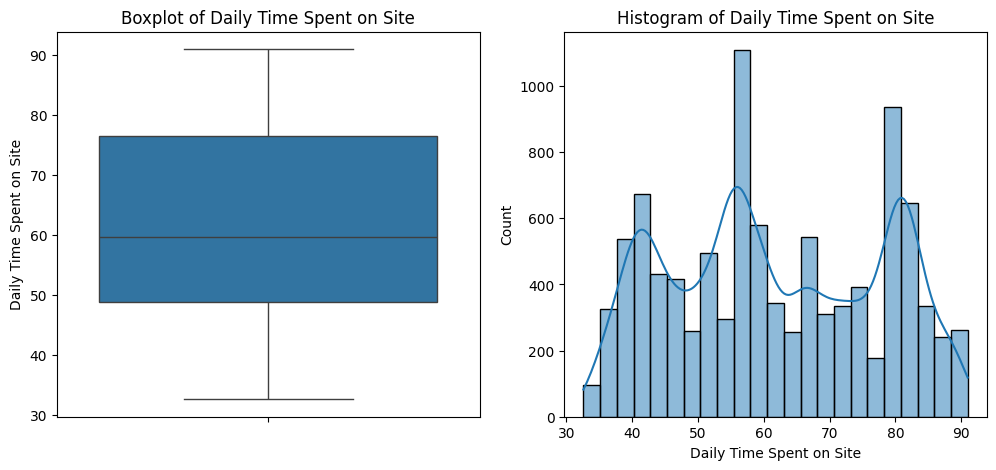

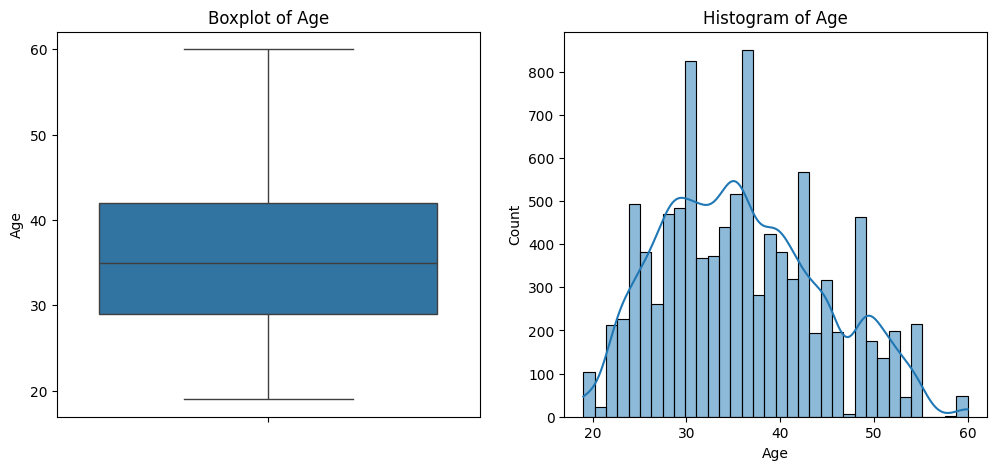

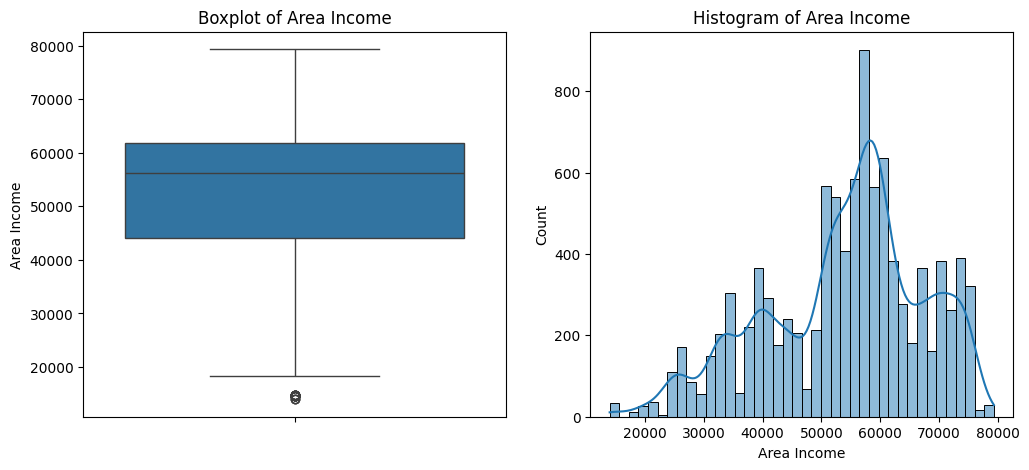

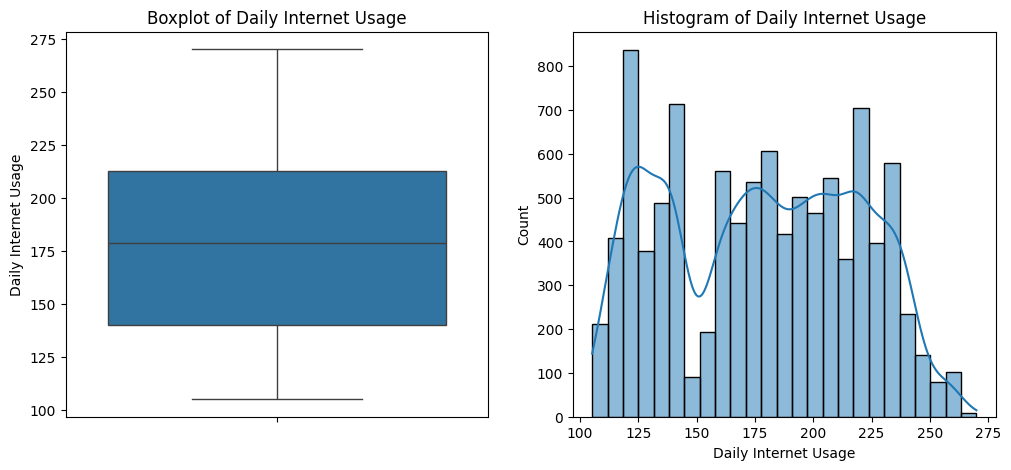

In [9]:
# EDA for numerical features
data_num = data[["Daily Time Spent on Site", "Age", "Area Income", "Daily Internet Usage"]]

# Univariate Analysis
for column in data_num.columns:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(y=data_num[column])
    plt.title(f'Boxplot of {column}')
    plt.subplot(1, 2, 2)
    sns.histplot(data_num[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.show()

  - The code is iterating through all possible pairs of numerical columns to create scatter plots that depict the relationships between these features.
   - The `combinations(data_num.columns, 2)` function is used to generate all possible pairs from the four numerical features (`"Daily Time Spent on Site"`, `"Age"`, `"Area Income"`, `"Daily Internet Usage"`).
   - The scatter plots are created using `plt.scatter()`, with `col1` on the x-axis and `col2` on the y-axis, which helps to visualize how one feature varies with respect to another.

2. Scatter Plot Analysis:
   - Scatter Plot Between Daily Time Spent on Site and Age:
     - The data points are quite scattered, suggesting no strong linear relationship between the time spent on the site and the user's age. It seems that users of all ages spend a similar amount of time on the website, with no clear pattern visible.
   - Scatter Plot Between Daily Time Spent on Site and Area Income:
     - Similar to the previous plot, the data points are dispersed throughout, indicating no distinct correlation between daily time spent on the site and the area income.
   - Scatter Plot Between Daily Time Spent on Site and Daily Internet Usage:
     - The plot reveals that daily internet usage is not directly linked to how much time is spent on this specific site. Users with different internet usage habits seem to spend varying amounts of time.
   - Scatter Plot Between Age and Area Income:
     - There seems to be some clustering, suggesting that younger users are more likely to have a specific range of income, but there is still substantial variation.
   - **Scatter Plot Between Age and Daily Internet Usage**:
     - There seems to be a more defined pattern where younger users may use the internet more, but it is not very strong, as there is still a lot of variability.
   - Scatter Plot Between Area Income and Daily Internet Usage:
     - This plot suggests a lack of clear association between area income and daily internet usage, as the points are scattered without any noticeable trend.

the scatter plots reveal no clear linear relationships between the features, which implies that these features may not be strongly correlated with one another.

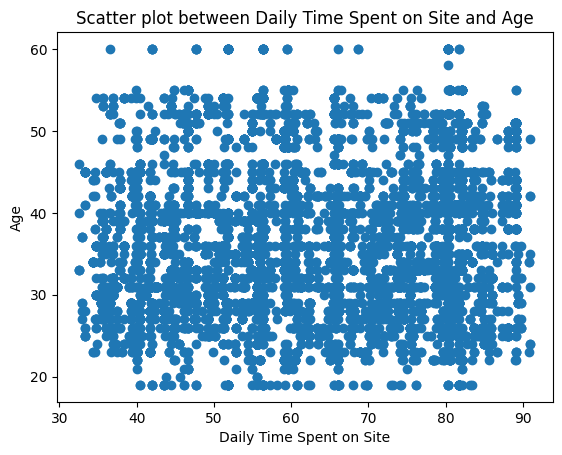

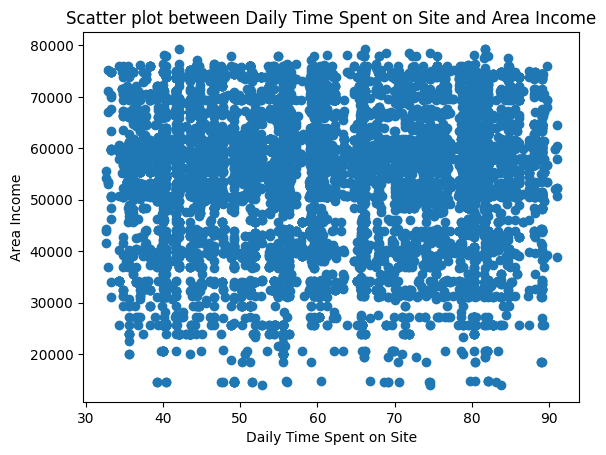

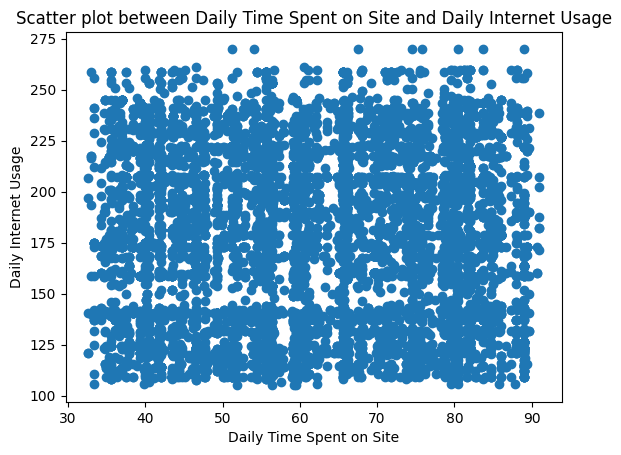

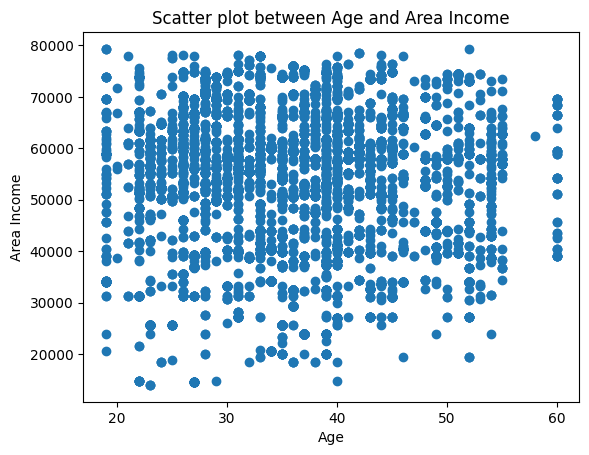

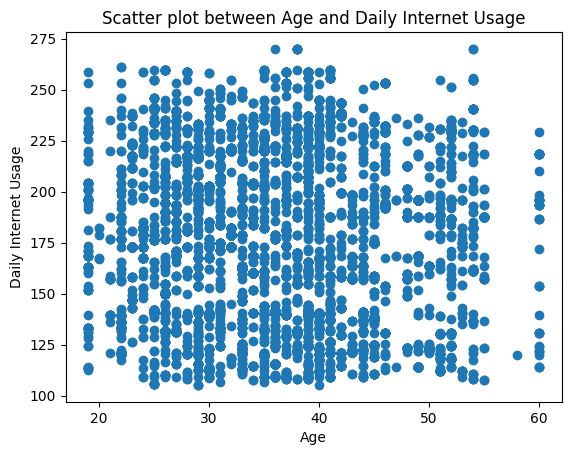

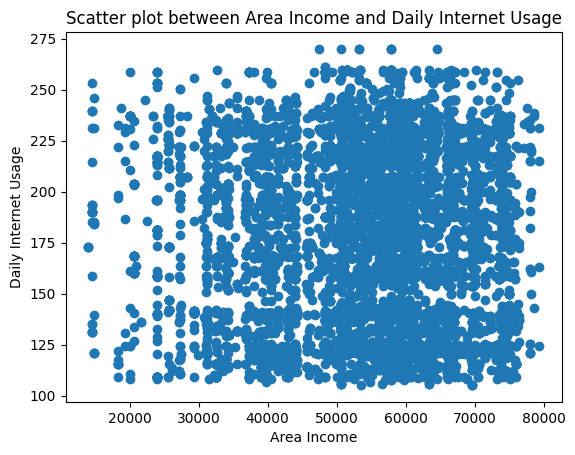

In [10]:
# Bivariate Analysis: Scatter plots
combinations_of_num_col = list(combinations(data_num.columns, 2))
for (col1, col2) in combinations_of_num_col:
    plt.figure()
    plt.scatter(data_num[col1], data_num[col2])
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title(f'Scatter plot between {col1} and {col2}')
    plt.show()

1. Categorical Data Analysis:
   - The categorical columns included `'Ad Topic Line'`, `'City'`, `'Gender'`, `'Country'`, `'Clicked on Ad'`, `'month'`, `'day'`, and `'hour'`.
   - For each column, if the number of unique values was less than 30, a bar plot and a pie chart were generated to visually inspect the data distribution.

2. Interpretation of Charts:
   - The bar chart for `Gender`shows that there is a relatively balanced distribution between males and females, with a slight difference (53.8% vs. 46.2%).
   - The charts for `Clicked on Ad`reveal a nearly equal split between users who clicked and did not click the ad, suggesting a balanced dataset for the target variable.
   - The charts for `month`and `hour`display user activity across months and hours, revealing notable trends like higher activity at specific times (e.g., hours 14, 16, and 21).

   - Bar Plot and Pie Chart:
  - The bar and pie charts provide a summary of the categorical features in the dataset. For instance, in the `Gender` plot, the distribution of males vs. females is nearly equal. The `Clicked on Ad` plot shows that users who clicked the ad are almost equal to those who did not, indicating a balanced dataset.

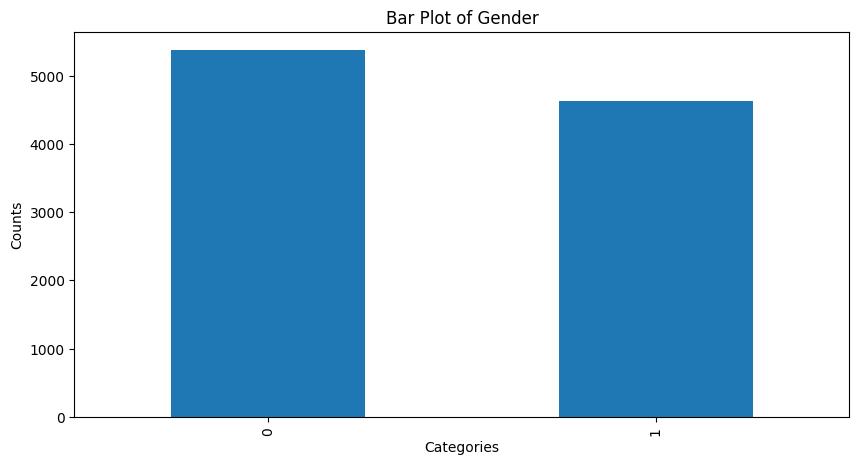

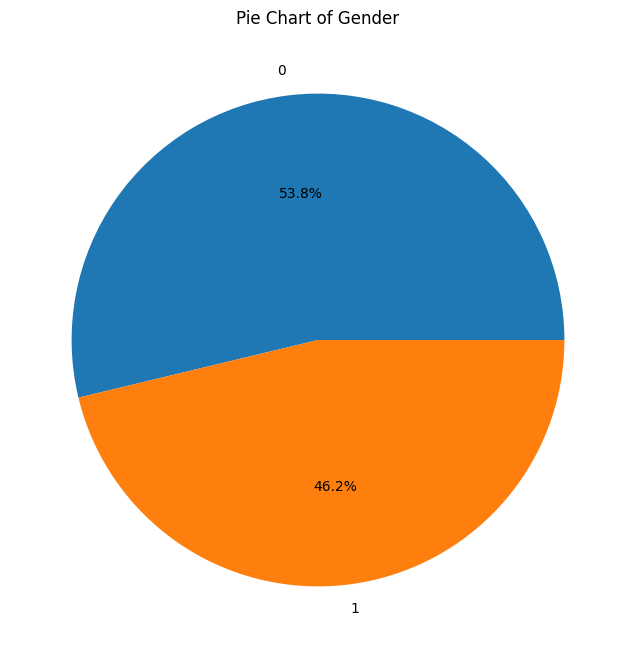

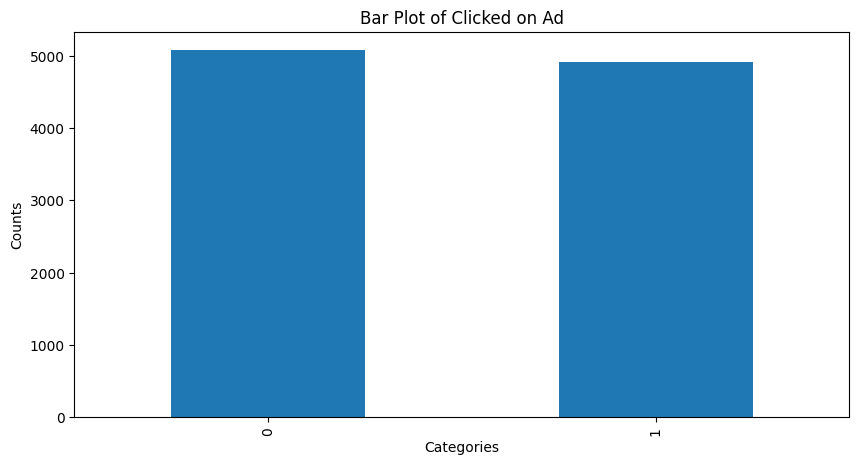

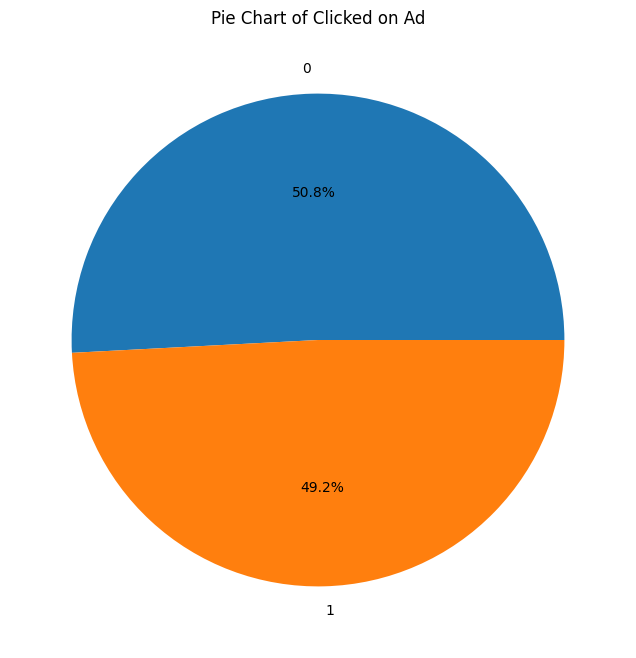

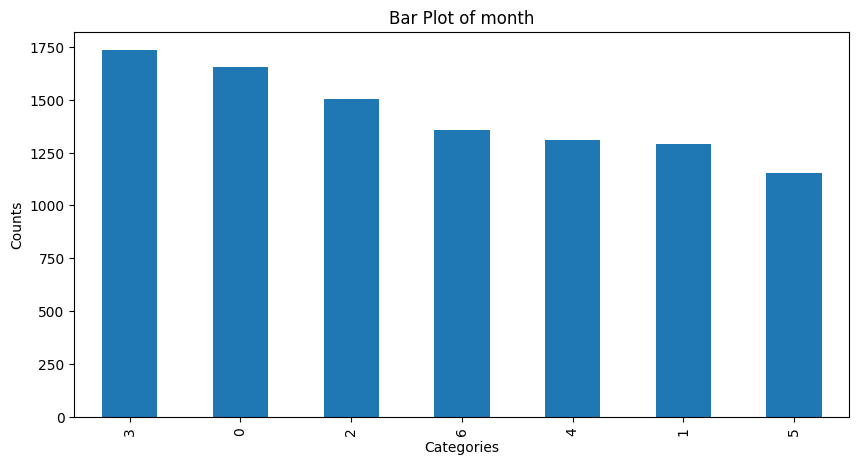

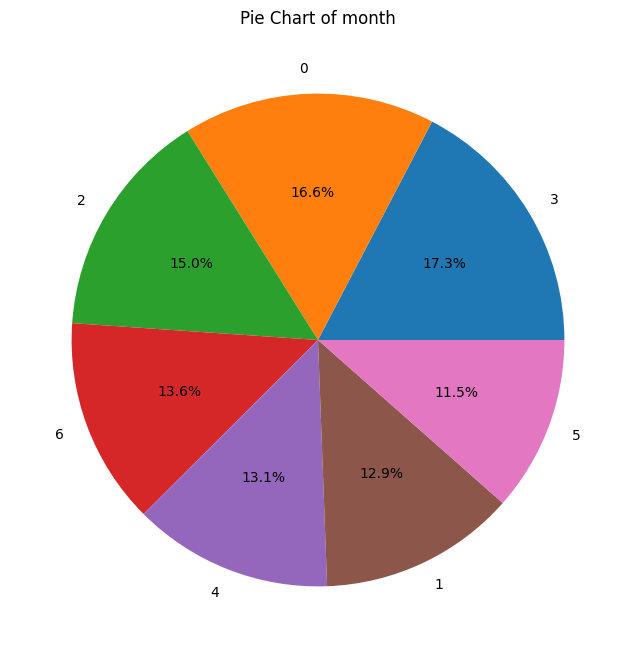

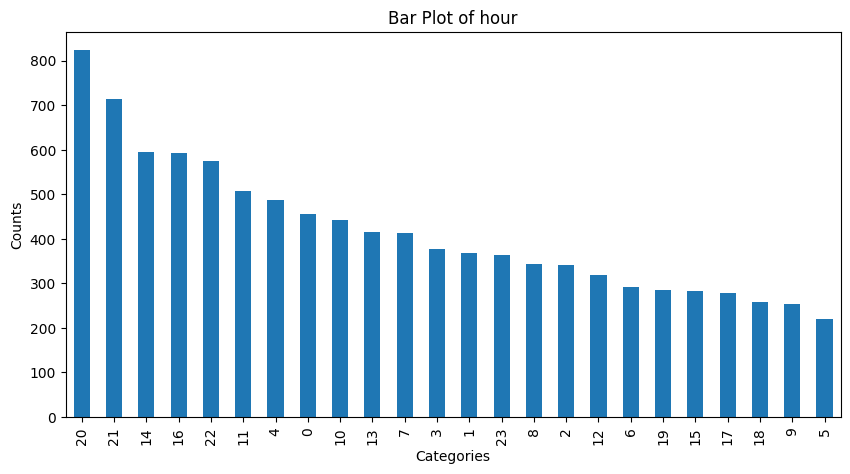

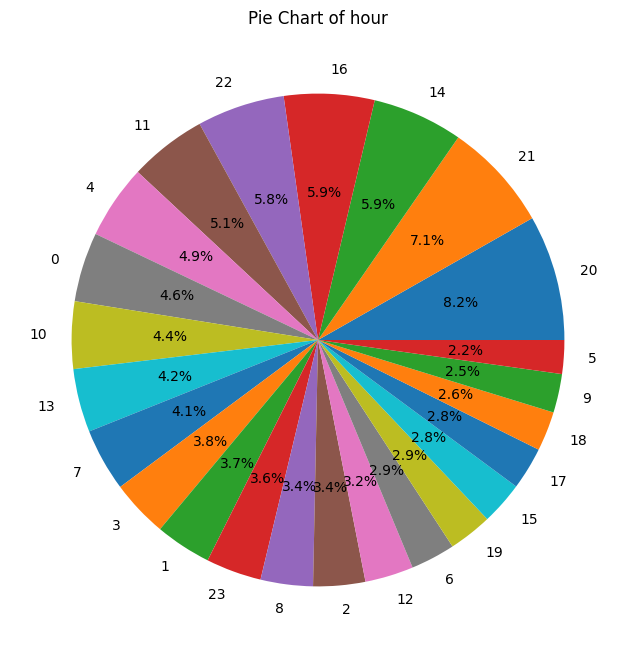

In [11]:
# Categorical Data Analysis
data_categorical = ['Ad Topic Line', 'City', 'Gender', 'Country', 'Clicked on Ad', 'month', 'day', 'hour']
for column in data_categorical:
    if len(data[column].unique()) < 30:
        count_data = data[column].value_counts()
        # Bar plot
        plt.figure(figsize=(10, 5))
        count_data.plot(kind='bar')
        plt.title(f'Bar Plot of {column}')
        plt.ylabel('Counts')
        plt.xlabel('Categories')
        plt.show()
        # Pie chart
        plt.figure(figsize=(8, 8))
        count_data.plot(kind='pie', autopct='%1.1f%%')
        plt.title(f'Pie Chart of {column}')
        plt.ylabel('')
        plt.show()


- Violin Plots for Numerical Features vs. Clicked on Ad: The violin plots are used to show the distribution of numerical features like `Daily Time Spent on Site`, `Age`, `Area Income`, and `Daily Internet Usage` across different groups, i.e., whether an ad was clicked or not.
- Violin Plots:
  - Violin plots for features like `Daily Time Spent on Site` and `Daily Internet Usage` show similar distributions between users who clicked the ad and those who did not, suggesting that these features may have similar impacts on user behavior.
  - For the `Age` feature, there is a wider distribution for users who clicked the ad, which might indicate a potential relationship between age and the likelihood of clicking on an ad.

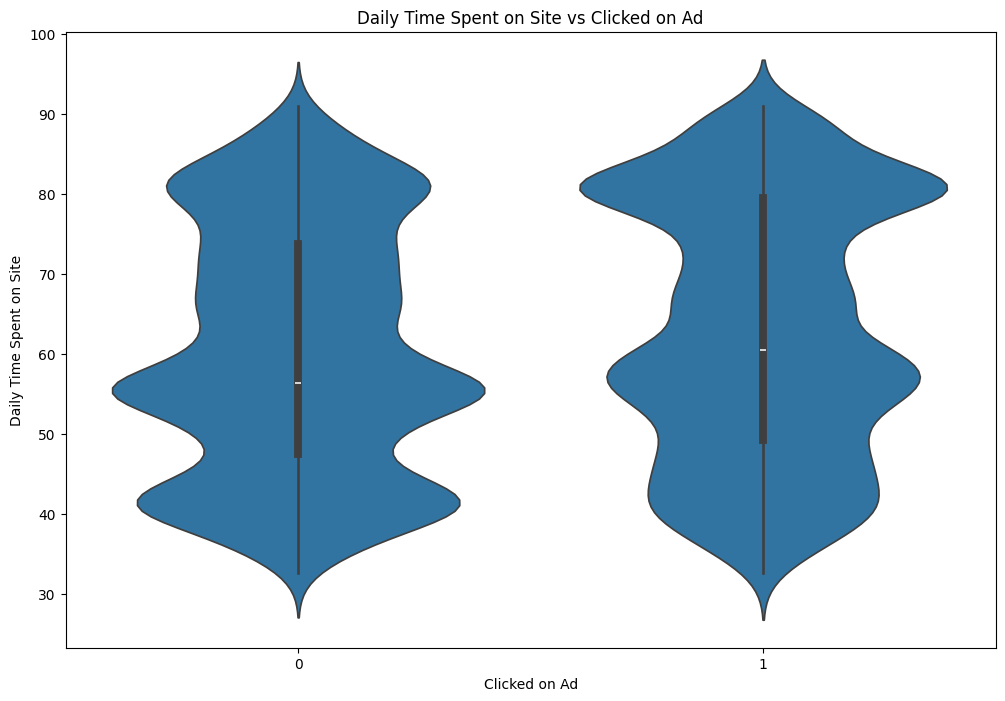

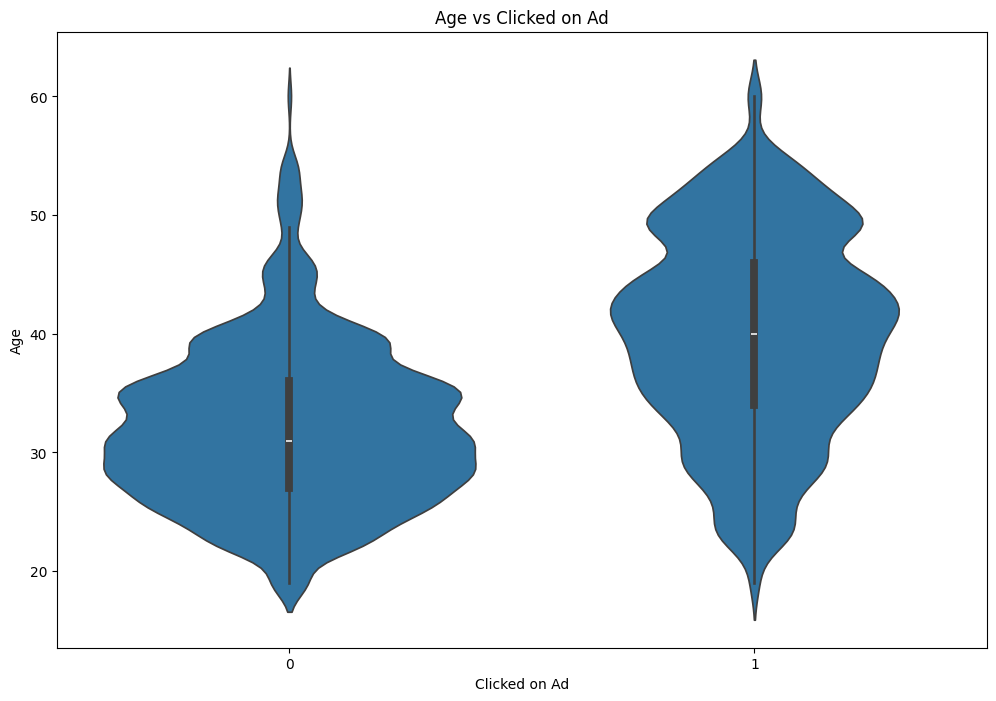

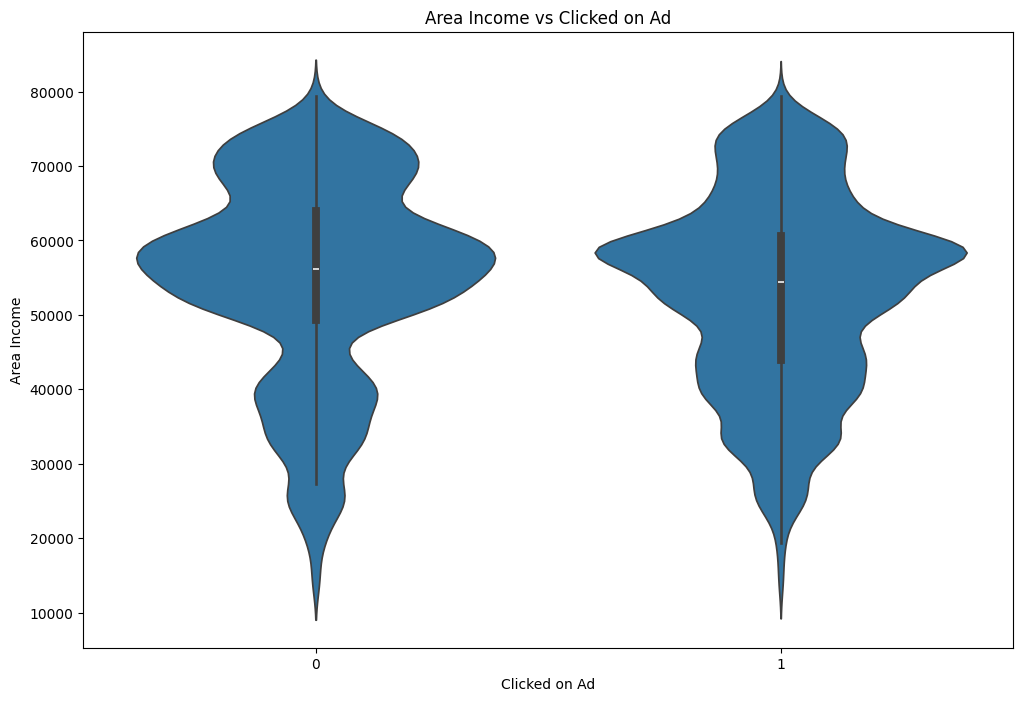

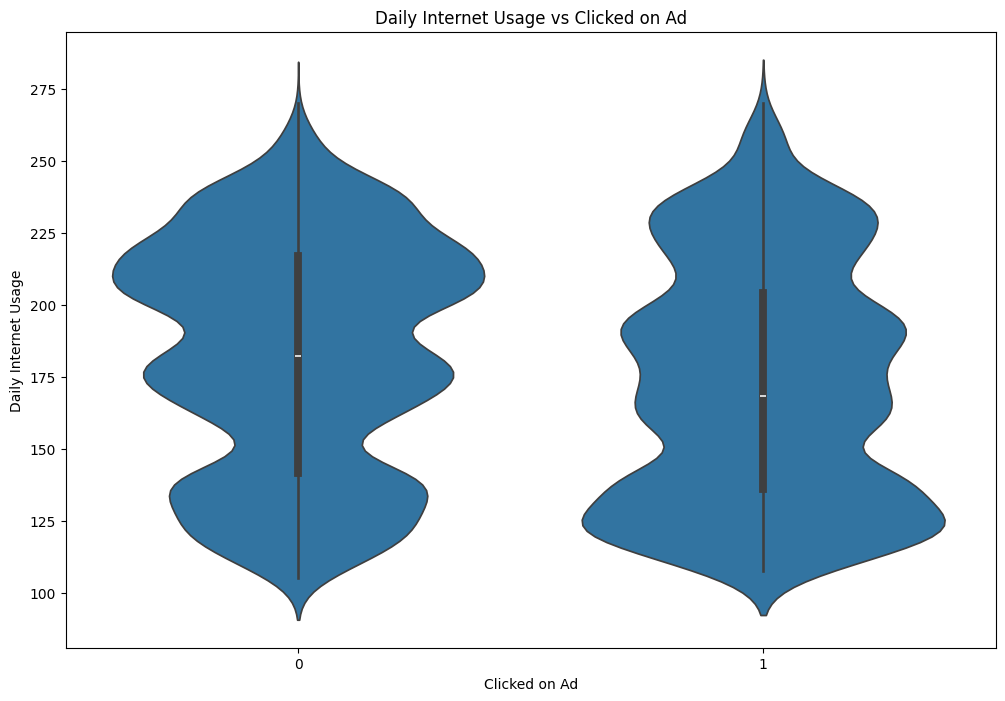

In [12]:
# Violin plots for numerical features vs Clicked on Ad
features = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']
for feature in features:
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='Clicked on Ad', y=feature, data=data)
    plt.title(f'{feature} vs Clicked on Ad')
    plt.show()

These density plots are a form of exploratory data analysis (EDA) that helps in understanding the patterns in the numerical features and how they differ for the two groups (clicked vs. not clicked).

### Analysis of Density Plots:
1. Daily Time Spent on Site by Clicked on Ad:
   - The density plot shows that users who clicked on the ad (orange) spent slightly less time compared to those who did not click (blue). This suggests that users who click ads may already be interested in the ad content and hence leave sooner, whereas those who did not click spent more time possibly browsing without finding it engaging enough to click.

2. Age by Clicked on Ad:
   - From the density plot of age, it appears that users who clicked (orange) are predominantly in the younger age range. The blue distribution peaks later, suggesting that users who do not click tend to be older. This indicates that age might be a significant predictor for ad engagement.

3. Area Income by Clicked on Ad:
   - The Area Income density plot shows a considerable overlap between the two groups, but there is a slight shift where users with slightly lower income are more likely to click on ads compared to those with higher incomes. This might indicate a socioeconomic influence on ad interactions.

4. Daily Internet Usage by Clicked on Ad:
   - The daily internet usage plot shows similar trends for clicked and not clicked groups, but there is a peak for non-clicked users at lower usage values. Users who clicked seem to have a more varied distribution. This suggests that users who spend more time online may also have a higher chance of interacting with ads.

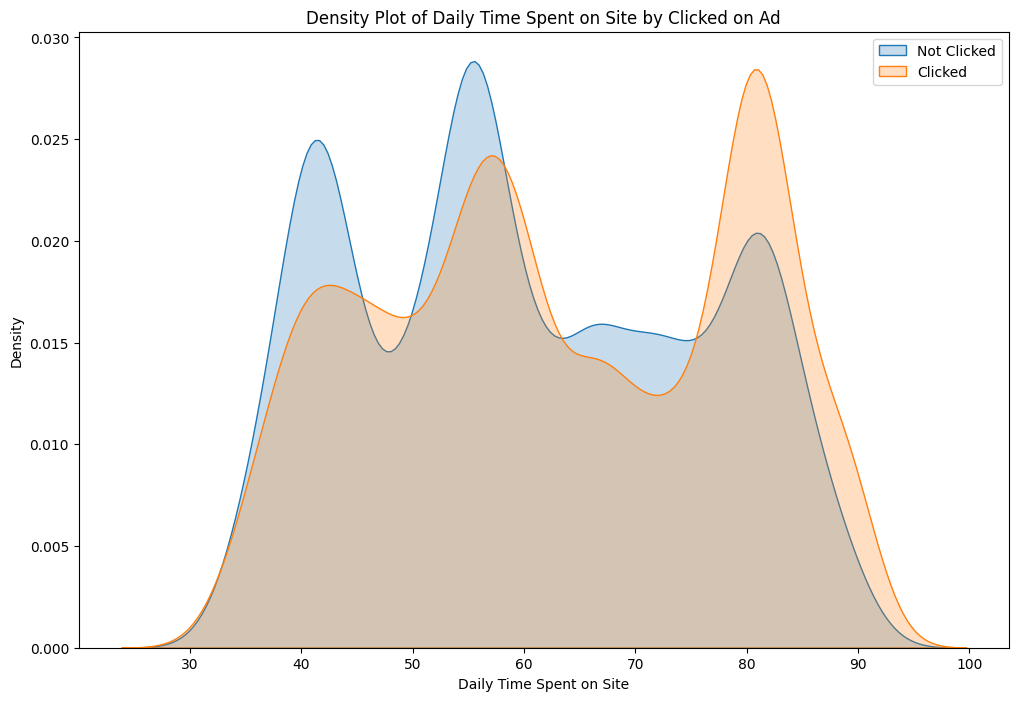

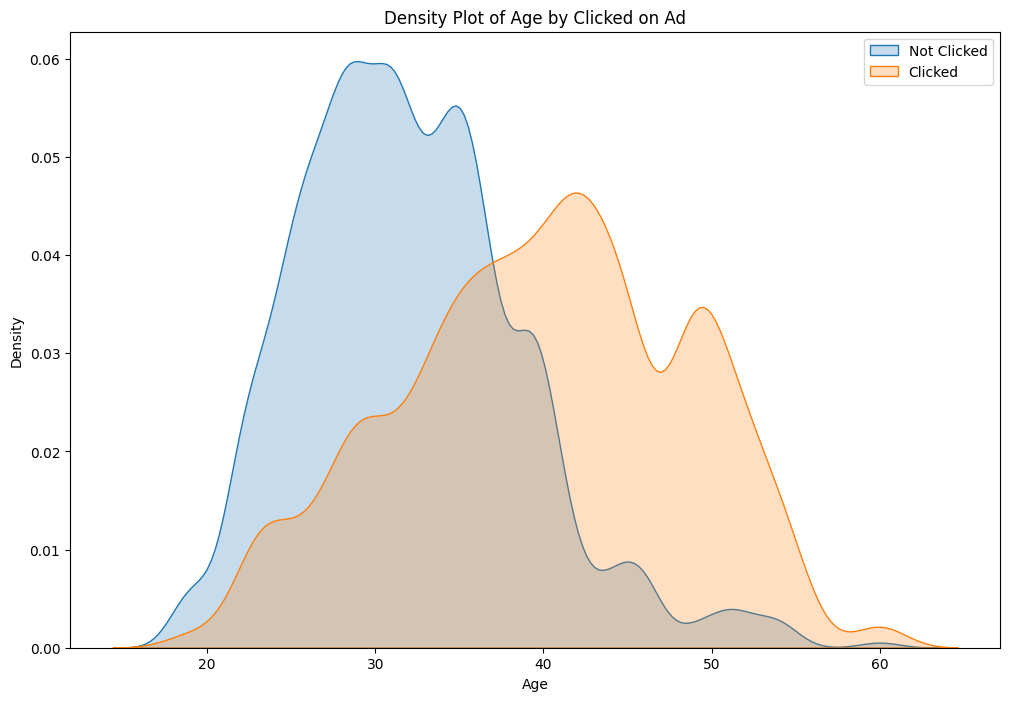

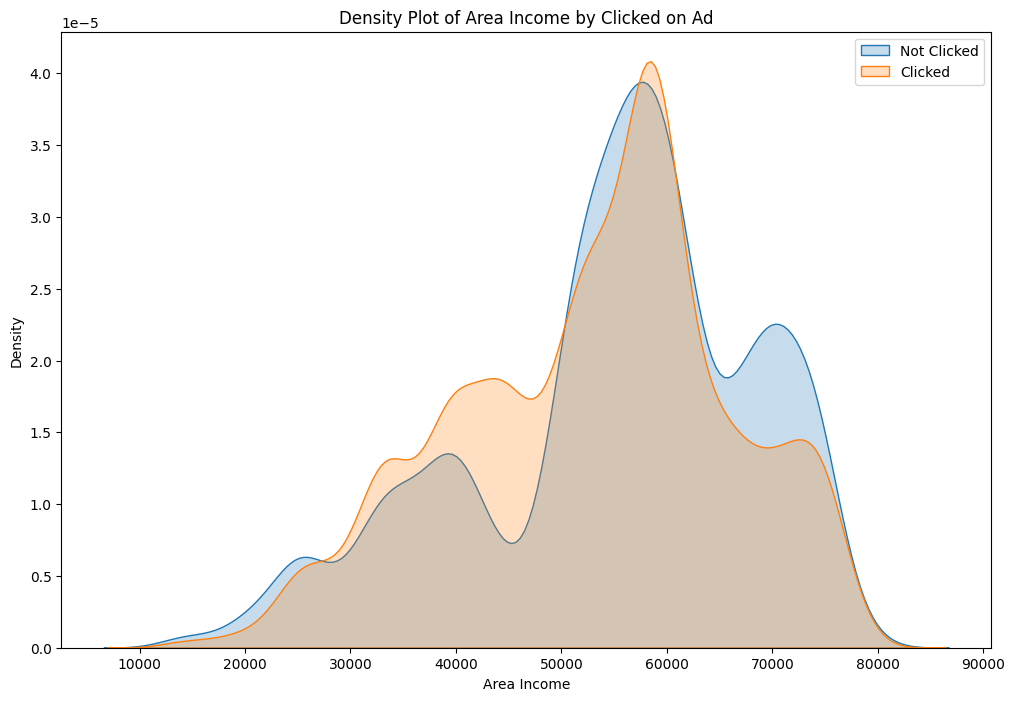

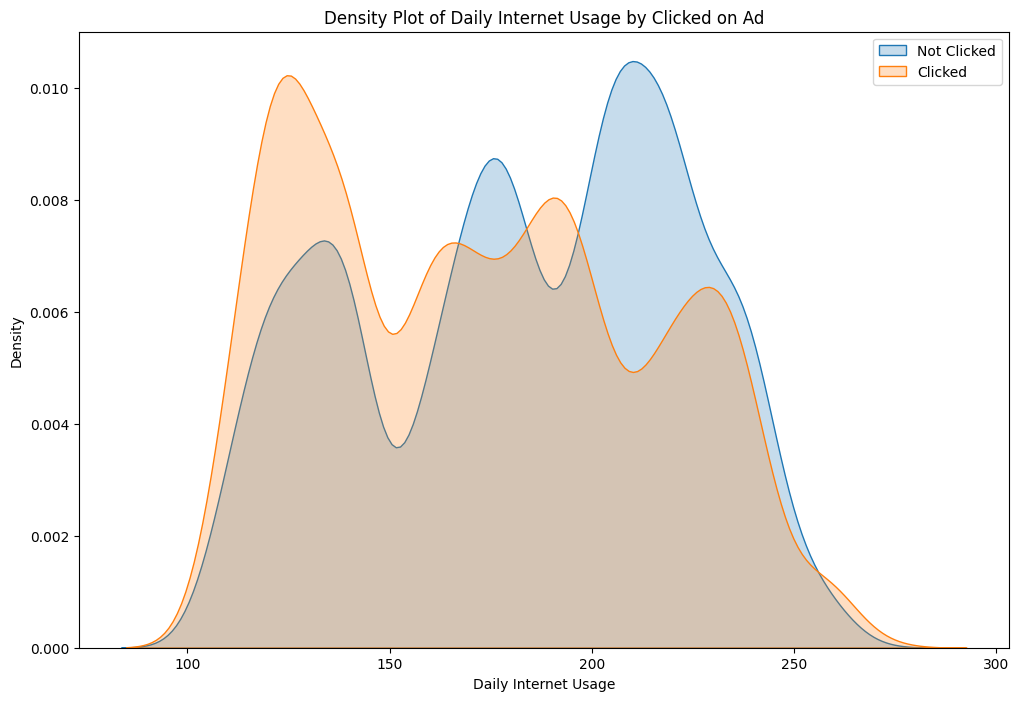

In [13]:
# Density plots for numerical features
for feature in features:
    plt.figure(figsize=(12, 8))
    sns.kdeplot(data=data[data['Clicked on Ad'] == 0][feature], shade=True, label='Not Clicked')
    sns.kdeplot(data=data[data['Clicked on Ad'] == 1][feature], shade=True, label='Clicked')
    plt.title(f'Density Plot of {feature} by Clicked on Ad')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

The code involves several steps to preprocess, analyze, and visualize data to understand the impact of different features on ad clicks.

1. Feature Engineering and Encoding:
   - New features such as `Hour`, `DayOfWeek`, and `Month` are extracted from the `Timestamp` to provide more granular temporal insights.
   - Categorical features `Gender` and `Country` are transformed into numerical values using `LabelEncoder`. This step is crucial for transforming non-numeric data into a form suitable for machine learning models.

2. Feature Scaling:
   - A `StandardScaler` is applied to features like `Daily Time Spent on Site`, `Age`, `Area Income`, and `Daily Internet Usage`. This step standardizes the features, which helps in improving model performance, especially for models sensitive to feature scaling like PCA.

3. Principal Component Analysis (PCA):
   - PCA is performed with 2 components to reduce the dimensionality of the dataset while retaining as much variance as possible. This allows visualization of the dataset in a simpler form.
   - The scatter plot visualizes how different data points are distributed along the two principal components (`PCA 1` and `PCA 2`). The data points are color-coded based on whether a user clicked on an ad or not. In the PCA plot, there seems to be a mixed overlap, indicating some level of complexity in separating the clicked vs not-clicked classes.


In [14]:
# Feature Engineering
data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek
data['Month'] = data['Timestamp'].dt.month

# Handle categorical variables using LabelEncoder
data['Gender'] = label_encoders['Gender'].fit_transform(data['Gender'])
data['Country'] = label_encoders['Country'].fit_transform(data['Country'])

# Scaling the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(data[['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']])

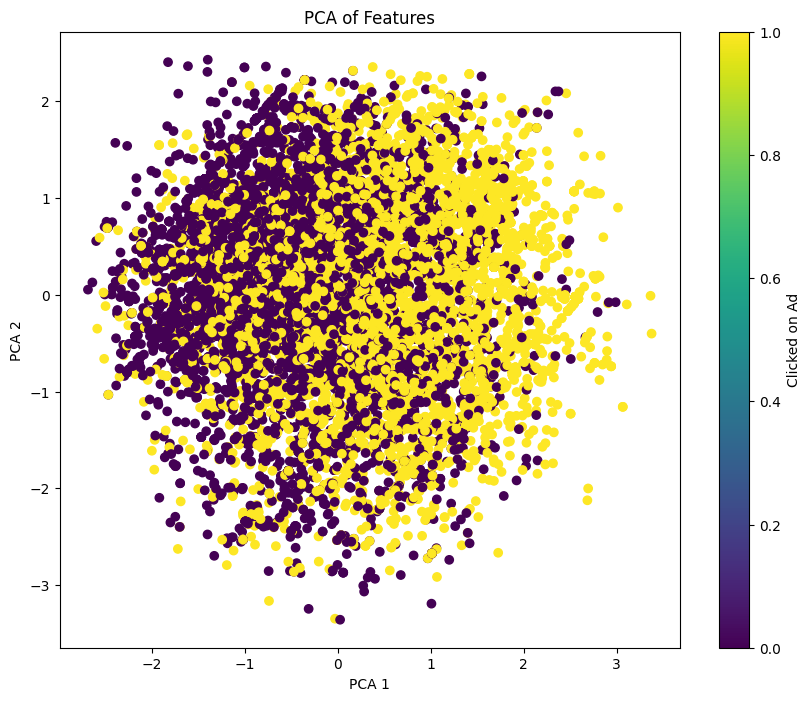

In [15]:
# Apply PCA
pca = PCA(n_components=2)
components = pca.fit_transform(features_scaled)

# Plot PCA
plt.figure(figsize=(10, 8))
plt.scatter(components[:, 0], components[:, 1], c=data['Clicked on Ad'])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Clicked on Ad')
plt.title('PCA of Features')
plt.show()

 Interaction Plot (Age vs Daily Internet Usage)
- Age vs Daily Internet Usage**: The scatter plot depicts the interaction between `Age` and `Daily Internet Usage`, colored by whether the user clicked on the ad (`Clicked on Ad`).
- Analysis: The distribution does not clearly separate the clicked (orange) from the not-clicked (blue) data points. However, we can observe some trends: users with lower age tend to have higher internet usage, and the likelihood of clicking on the ad is more evenly distributed in certain age brackets.

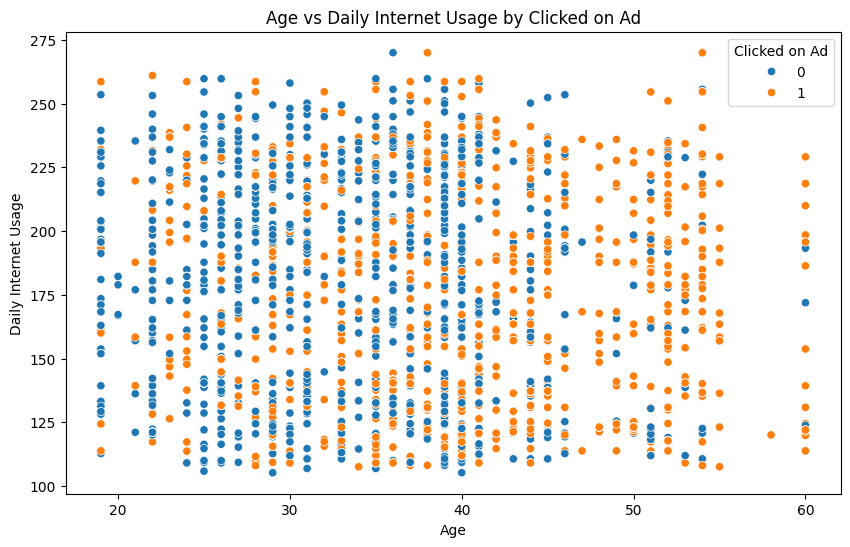

In [16]:
# Interaction: Age vs Daily Internet Usage colored by Clicked on Ad
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Age', y='Daily Internet Usage', hue='Clicked on Ad', data=data)
plt.title('Age vs Daily Internet Usage by Clicked on Ad')
plt.show()

Bar Plot (Top 10 Countries vs Clicked on Ad)
- The bar plot displays the number of users from the top 10 countries by interaction status (clicked or not clicked).
- Each country is represented on the y-axis, and counts are represented on the x-axis. The blue bars indicate users who did not click the ad, whereas orange bars represent those who did.
- The visualization helps identify if users from certain countries are more likely to engage with advertisements, providing insight into the geographical performance of the ads.

These visualizations serve as exploratory data analysis tools to help understand how user demographics and behaviors relate to advertisement clicks.

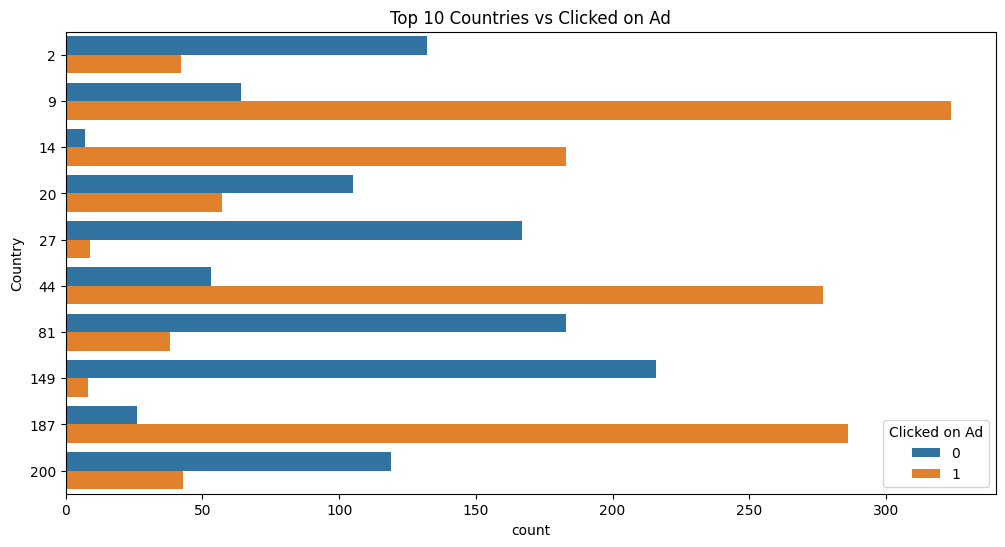

In [19]:
# Additional visualizations
top_countries = data['Country'].value_counts().index[:10]
plt.figure(figsize=(12, 6))
sns.countplot(y='Country', hue='Clicked on Ad', data=data[data['Country'].isin(top_countries)])
plt.title('Top 10 Countries vs Clicked on Ad')
plt.show()


Gender vs. Clicked on Ad:
   - This bar plot displays the count of users who clicked on the ad by gender.
   - It suggests a possible pattern in ad clicking behavior based on gender. For instance, there seems to be a slight variation in the proportion of clicks between the two genders, which could indicate targeting opportunities based on gender preferences.


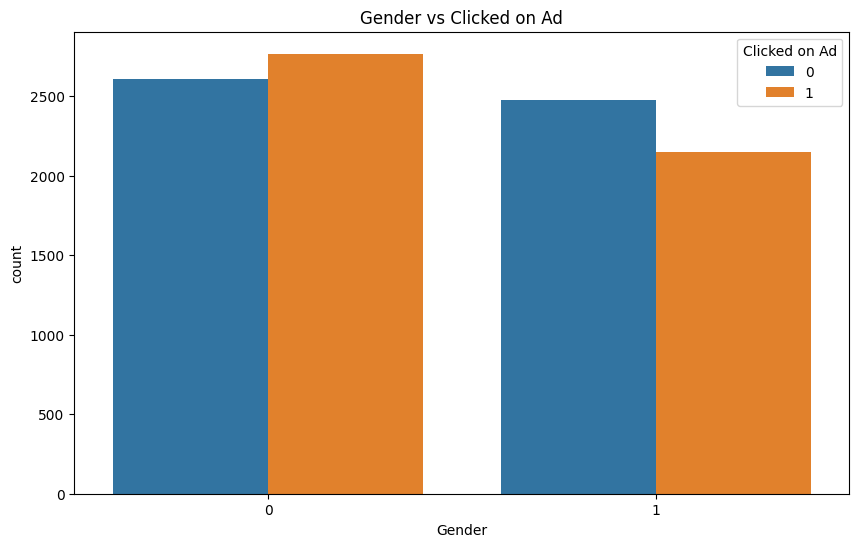

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Gender', hue='Clicked on Ad', data=data)
plt.title('Gender vs Clicked on Ad')
plt.show()

Correlation Matrix
The heatmap presents the correlation matrix of numerical features, illustrating relationships between variables. The correlation values range from -0.059 to 0.1, showing that there is no strong linear relationship among features such as daily time spent on site, age, area income, and daily internet usage. This suggests that none of these features have a particularly strong linear influence on each other.

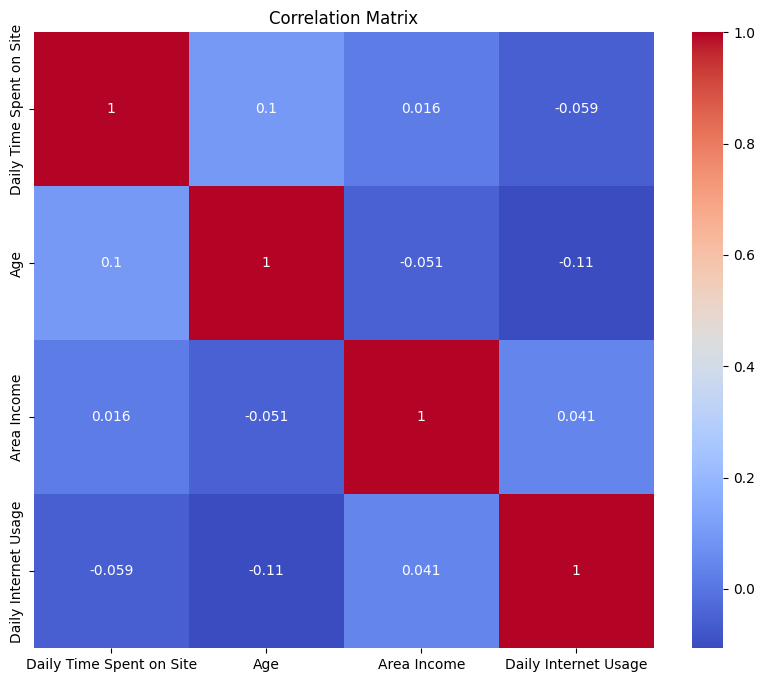

In [18]:
# Heatmap of correlations
plt.figure(figsize=(10, 8))
correlation_matrix = data_num.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Feature Preparation and Target Variables:
   - The dataset is being used to create a feature matrix `X` and a target vector `y`.
   - Features `X` are extracted by dropping the columns `Clicked on Ad` and `Timestamp`, which are not needed for training.
   - The target variable `y` is the `Clicked on Ad` column, which is converted to an integer type to facilitate classification.

Splitting Data:
   - The dataset is split into training and test sets using the `train_test_split` function from `scikit-learn`.
   - 20% of the data is reserved for testing (`test_size=0.2`), while the rest is used for training the models.

Data Leakage Prevention
   - There is a clear separation of training and test datasets using `train_test_split()`, ensuring no data leakage.
   this part of the code ensures that **data leakage** is prevented in the following ways:

1. Feature and Target Separation: The `Clicked on Ad` (target variable) is separated from the feature variables (`X`) before splitting the data. This ensures that the target variable is not inadvertently included as a feature during model training, which could lead to data leakage

2. Timestamp Removal: The `Timestamp` column is also dropped from the features. Including time-based information without proper handling can lead to data leakage, as timestamps may reveal patterns that inadvertently help in predictions. By removing it, potential leakage from this column is avoided.

3. Train-Test Split: The data is split into training and testing sets using `train_test_split()`, with a test size of 20%. This separation ensures that the model is trained on one set of data (training) and evaluated on another unseen set (test), preventing the model from learning patterns specific to the test data, which would result in data leakage.

In [21]:
# Prepare features and target variables
X = data.drop(['Clicked on Ad','Timestamp'], axis=1)
y = data['Clicked on Ad'].astype(int)  # Ensure the target is integer type

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Model Definition:
   - Several models are defined in a dictionary named `models`:
     - Logistic Regression: a linear model used for binary classification.
     - Decision Tree (Random Forest Classifier): a tree-based model used for classification tasks.
     - XGBoost: an advanced tree-based algorithm for both classification and regression.
     - CatBoost: another gradient boosting method optimized for categorical features.
     - SVM (Support Vector Machine): used for classification, utilizing a kernel-based approach.

In [22]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', enable_categorical=True),
    'CatBoost': CatBoostClassifier(verbose=0),
    'SVM': SVC(probability=True)
}

Cross-Validation and Evaluation:
   - Cross-validation is used to evaluate each model's performance on the training data. Cross-validation helps to understand how well a model will generalize to new, unseen data.
   - The loop iterates through each model:
     - If the model is CatBoost, categorical features are specified explicitly.
     - The `cross_val_score()` function performs 5-fold cross-validation and calculates the accuracy score for each fold.
     - For each model, the mean accuracy and standard deviation are printed to provide insights into the model's stability and performance.

Results:
   - The printed results show the cross-validation accuracy for each model:
     - Logistic Regression: Mean Accuracy = 0.7056 ± 0.0125
     - Decision Tree: Mean Accuracy = 0.8463 ± 0.0083
     - XGBoost: Mean Accuracy = 0.8729 ± 0.0070
     - CatBoost: Mean Accuracy = 0.8912 ± 0.0063
     - SVM: Mean Accuracy = 0.5553 ± 0.0155
- Model Comparison:
  - Among the five models evaluated, CatBoost shows the highest cross-validation accuracy (`0.8912 ± 0.0063`), indicating that it performs best on this dataset.
  - XGBoost also performs well, with a cross-validation accuracy of `0.8729 ± 0.0070`, which is very close to CatBoost.
  - Decision Tree comes next, performing reasonably well (`0.8463 ± 0.0083`).
  - Logistic Regression performs moderately (`0.7056 ± 0.0125`), while SVM has the lowest performance (`0.5553 ± 0.0155`).

- Performance Insights:
  - The results suggest that ensemble models like CatBoost and XGBoost perform better than simpler models such as Logistic Regression and  SVM.
  - The standard deviationof the cross-validation accuracy indicates the consistency of the model's performance across different folds. Lower standard deviation values, like those of CatBoost and XGBoost, suggest more stable performance.

-CatBoost is the best-performing model for this task, with the highest accuracy and a low standard deviation, making it both effective and reliable.


In [23]:
# Cross-validation and evaluation
results = {}
for model_name, model in models.items():
    if model_name == 'CatBoost':
        # Specify cat_features for CatBoost during cross-validation
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', fit_params={'cat_features': list(X_train.select_dtypes(include='category').columns)})
    else:
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    results[model_name] = scores
    print(f"{model_name} Cross-Validation Accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Logistic Regression Cross-Validation Accuracy: 0.7056 ± 0.0125
Decision Tree Cross-Validation Accuracy: 0.8463 ± 0.0083
XGBoost Cross-Validation Accuracy: 0.8729 ± 0.0070
CatBoost Cross-Validation Accuracy: 0.8912 ± 0.0063
SVM Cross-Validation Accuracy: 0.5553 ± 0.0155



The code is for evaluating the performance of different machine learning models on a dataset.
1. Model Evaluation Loop
- The code iterates over each model defined earlier in the notebook.
- The models include `Logistic Regression`, `Decision Tree`, `XGBoost`, `CatBoost`, and `SVM`.
2. CatBoost Specific Treatment
- If the model is `CatBoost`, categorical features are specifically handled by passing `cat_features` during model fitting.
3. Model Fitting and Prediction
- For other models (`Logistic Regression`, `Decision Tree`, etc.), the models are trained (`fit`) on the training data (`X_train` and `y_train`).
- After fitting, predictions (`y_pred`) are made on the test dataset (`X_test`).
- If the model supports probability prediction (`predict_proba`), the code also calculates the predicted probabilities (`y_pred_proba`).
4. Model Performance Metrics
- Classification Report: For each model, a detailed classification report is printed. It contains metrics like `precision`, `recall`, `f1-score`, and `support` for each class.
- Accuracy: The overall accuracy of the model on the test set is printed.
- Confusion Matrix: A confusion matrix is printed to give more insights into how well the model performs in distinguishing between the different classes.
5. ROC Curve
- If `y_pred_proba` is available, a ROC (Receiver Operating Characteristic) curve is plotted for each model.
- The ROC curve helps visualize the performance of the model by plotting the `True Positive Rate` against the `False Positive Rate`.
- The AUC (Area Under Curve) is also displayed in the plot legend, indicating the model's ability to distinguish between classes.
6. Example Output for Logistic Regression
- The output shows the classification report for `Logistic Regression` with metrics:
  - Precision for classes `0` and `1` are `0.69` and `0.72`, respectively.
  - Recall is `0.75` for class `0` and `0.68` for class `1`.
  - The `f1-score` for both classes is around `0.72`.
  - These metrics indicate the balance between precision and recall.

- This code systematically evaluates each model based on multiple metrics, allowing comparison between different classifiers.
- Cross-validation (earlier in the notebook) provides an estimate of how well each model is likely to perform on unseen data, while this evaluation gives a deeper analysis using various metrics on a validation set.
- Models like `CatBoost` are given special treatment to utilize their full capabilities, including handling categorical features.

This detailed evaluation helps in selecting the best-performing model based on both accuracy and other metrics like precision, recall, and the AUC score, providing a comprehensive understanding of each model's performance.
1. Logistic Regression
- Precision, Recall, and F1-Score: The model achieves moderate precision and recall with an F1-score of approximately 0.70.
- Accuracy: The overall accuracy is 0.7030, which means the model correctly predicted around 70.3% of the instances.
- ROC Curve and AUC: The Area Under the Curve (AUC) for the ROC is 0.7624, indicating a decent performance, but not particularly strong in terms of true-positive versus false-positive balance.
2. Decision Tree
- Precision, Recall, and F1-Score: The Decision Tree performed well, with precision and recall for both classes close to 0.85.
- Accuracy: The accuracy is 0.8530, which is considerably higher than the Logistic Regression.
- ROC Curve and AUC: The AUC for the Decision Tree is 0.9319, which suggests that the model is very effective at distinguishing between the positive and negative classes.
3. XGBoost
- Precision, Recall, and F1-Score: XGBoost provided an F1-score of 0.89 for both classes, with an accuracy of 0.8900.
- ROC Curve and AUC: The ROC AUC score is 0.9531, which indicates excellent performance, making this model very strong in differentiating between classes.
 4. CatBoost
- Precision, Recall, and F1-Score: The model performed exceptionally well, with an accuracy of 0.9060 and an F1-score of 0.91.
- ROC Curve and AUC: The AUC is 0.9641, suggesting the best performance among all models in the ability to correctly classify both positive and negative examples.
 5. Support Vector Machine (SVM)
- Precision, Recall, and F1-Score: The SVM model did not perform well compared to other models, with an overall accuracy of 0.5440. Precision and recall for both classes were also low, indicating potential issues with separability in the dataset.
- ROC Curve and AUC: The AUC for the SVM was 0.5712, reflecting weak performance, possibly due to the complexity of the data and lack of hyperparameter tuning.
- Best Performing Model: The CatBoost model demonstrated the highest accuracy (0.9060) and AUC (0.9641), suggesting that it is the most effective for this classification task.
- Second Best: XGBoost also performed very well, but slightly lower than CatBoost, especially in accuracy and AUC.
- Weakest Performance: The SVM had the lowest scores across all metrics, indicating that it might not be suitable for this dataset without further adjustments.
These results suggest that for classification problem, tree-based methods like CatBoost and XGBoost are highly effective. In contrast, linear methods (like Logistic Regression) and SVM require more careful tuning or feature engineering to match the performance of these ensemble methods.


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      1014
           1       0.72      0.65      0.68       986

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000

Accuracy: 0.7030
Confusion Matrix:
[[761 253]
 [341 645]]


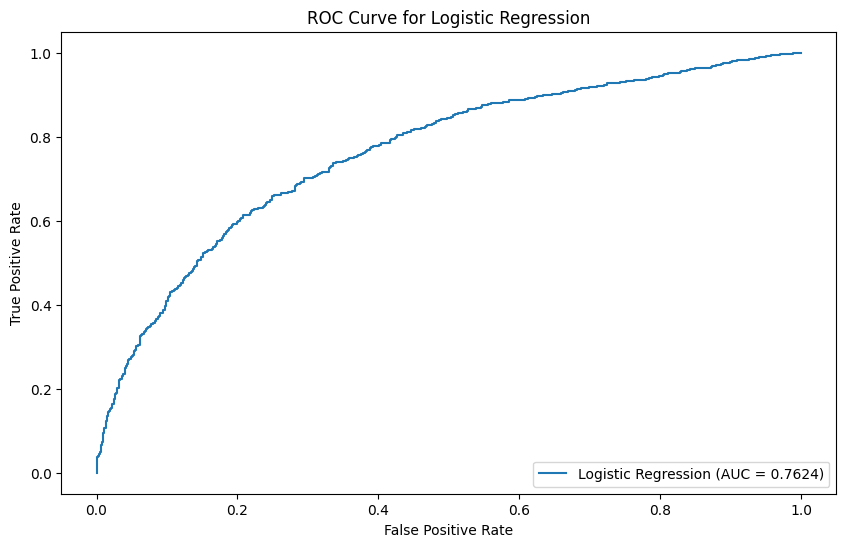


Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1014
           1       0.86      0.84      0.85       986

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Accuracy: 0.8530
Confusion Matrix:
[[880 134]
 [160 826]]


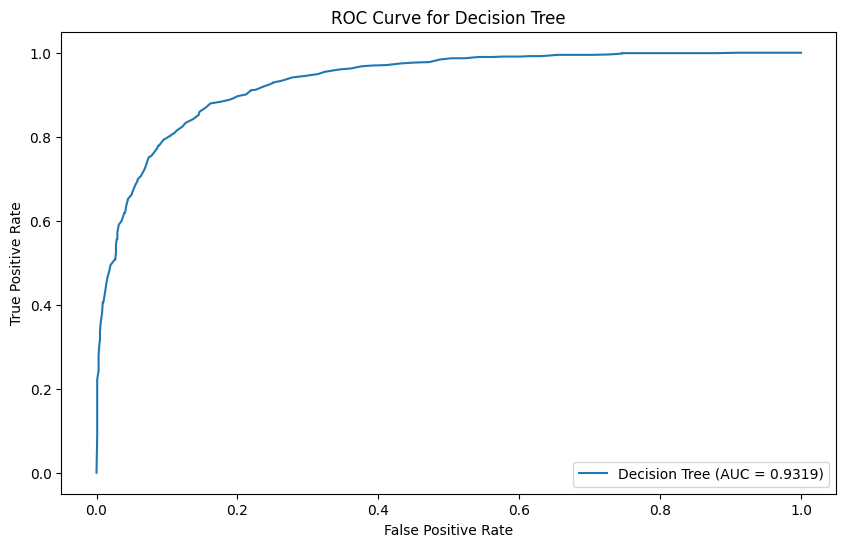


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1014
           1       0.88      0.90      0.89       986

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Accuracy: 0.8900
Confusion Matrix:
[[897 117]
 [103 883]]


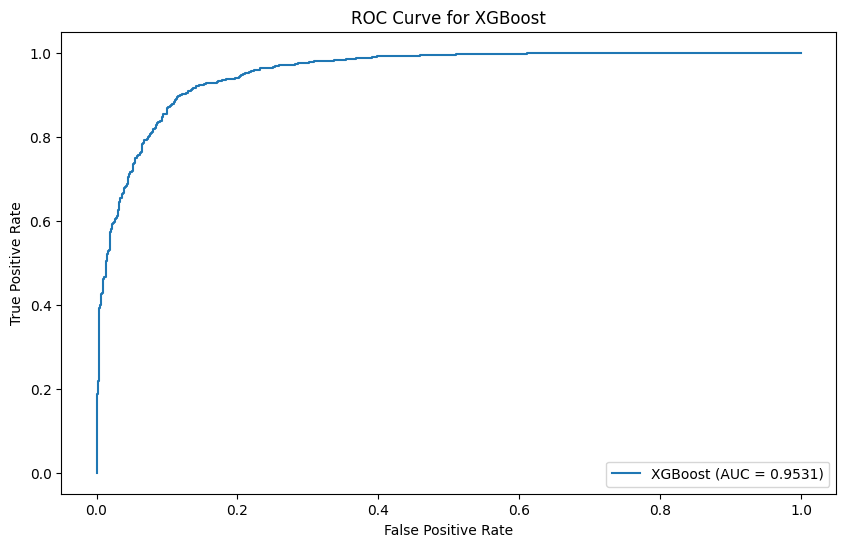


CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1014
           1       0.90      0.91      0.91       986

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000

Accuracy: 0.9060
Confusion Matrix:
[[913 101]
 [ 87 899]]


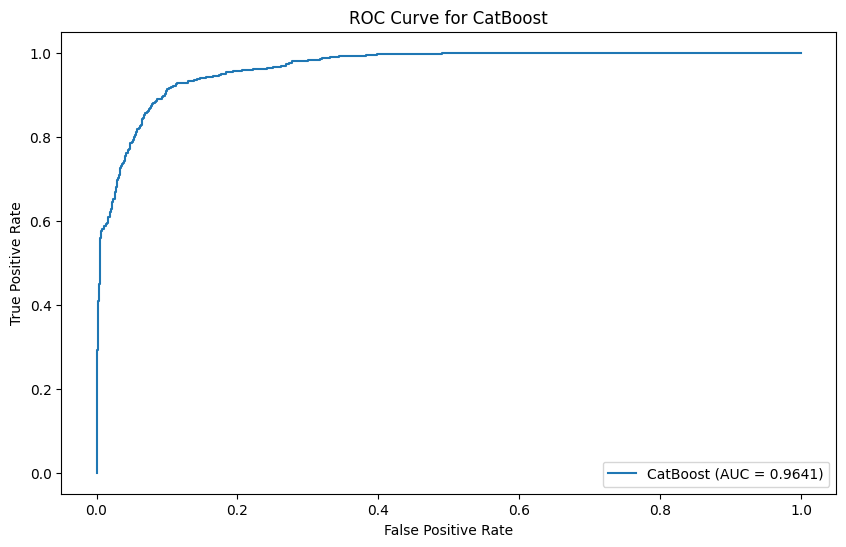


SVM Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.61      0.57      1014
           1       0.54      0.48      0.51       986

    accuracy                           0.54      2000
   macro avg       0.54      0.54      0.54      2000
weighted avg       0.54      0.54      0.54      2000

Accuracy: 0.5440
Confusion Matrix:
[[614 400]
 [512 474]]


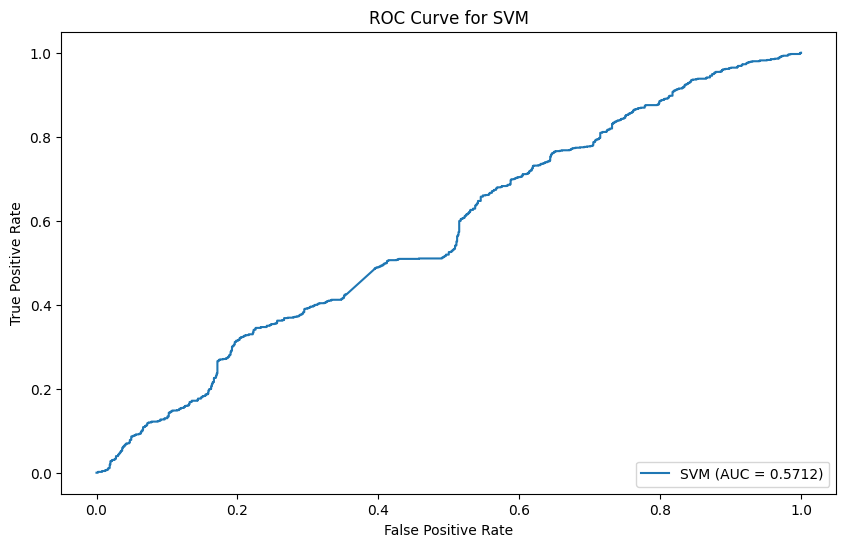

In [24]:
# Model evaluation
for model_name, model in models.items():
    if model_name == 'CatBoost':
        # Fit with cat_features specified
        model.fit(X_train, y_train, cat_features=list(X_train.select_dtypes(include='category').columns))
    else:
        model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    print(f"\n{model_name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(10, 6))
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc='lower right')
        plt.show()


1. Cross-Validation Results Calculation:
   - The code block initializes a dictionary `cv_results` to store the mean and standard deviation of cross-validation scores for five models: `Logistic Regression`, `Decision Tree`, `XGBoost`, `CatBoost`, and `SVM`.
   - For each model, the cross-validation accuracy metrics (`mean` and `std`) are saved.

2. Visualization of Model Performance:
   - The following plot is generated:
     - A bar plot representing the cross-validation accuracy (`mean`) of each model, with error bars indicating the standard deviation (`std`).
     - Each bar is color-coded, with different colors representing different models.
     - The accuracy ranges from 0 to 1, as represented on the y-axis.
 Model Performance:
   - `CatBoost` (in purple) and `XGBoost` (in red) achieve the highest cross-validation accuracy, around 0.90, indicating that these models are the best performers among the given options.
   - `Decision Tree` (green) performs reasonably well, with a mean accuracy slightly above 0.75.
   - `Logistic Regression` (blue) achieves moderate accuracy, around 0.70.
   - `SVM` (orange) has the lowest accuracy, approximately 0.54, indicating that it may not be as suitable for the dataset as the other models.

   - The error bars show the consistency of the models during cross-validation.
   - `CatBoost` has the highest accuracy and seems to have lower variability, implying it is a stable and effective model for this problem.
   - `SVM` has both the lowest accuracy and relatively high variability, which suggests it is underperforming and less reliable for this particular dataset.

based on cross-validation results, `CatBoost` and `XGBoost` should be prioritized for further evaluation, while `SVM` might be excluded due to its poor performance.

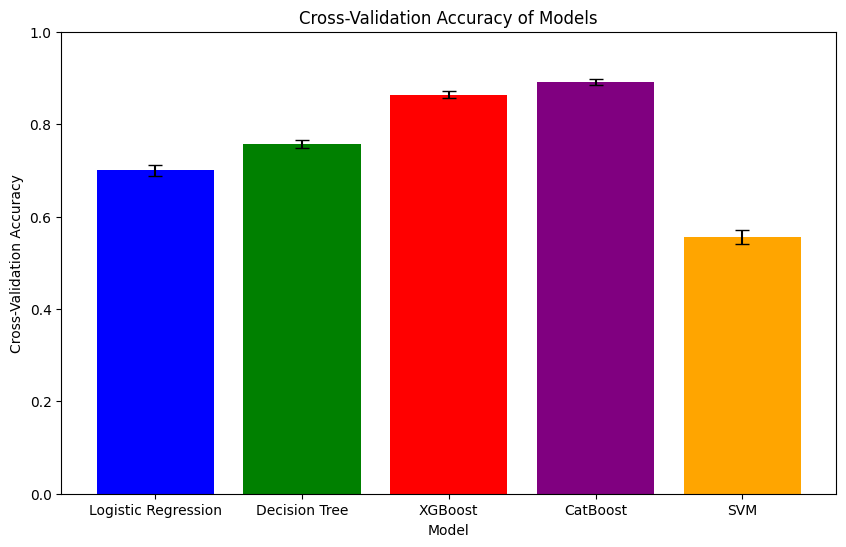

In [28]:
# Visualization of model performance
cv_results = {
    'Logistic Regression': {'mean': 0.6997, 'std': 0.0119},
    'Decision Tree': {'mean': 0.7571, 'std': 0.0082},
    'XGBoost': {'mean': 0.8634, 'std': 0.0074},
    'CatBoost': {'mean': np.mean(results['CatBoost']), 'std': np.std(results['CatBoost'])},
    'SVM': {'mean': np.mean(results['SVM']), 'std': np.std(results['SVM'])}
}

# Barplot for accuracies
plt.figure(figsize=(10, 6))
model_names = list(cv_results.keys())
cv_means = [cv_results[model]['mean'] for model in model_names]
cv_stds = [cv_results[model]['std'] for model in model_names]
plt.bar(model_names, cv_means, yerr=cv_stds, capsize=5, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Model')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Accuracy of Models')
plt.ylim(0, 1)
plt.show()


- Confusion Matrix Visualization:
  - The code is generating confusion matrices for different models to visualize the classification performance.
  - The confusion matrices are created for Logistic Regression, Decision Tree, XGBoost, CatBoost, and SVM classifiers. Each model's prediction is compared to the true labels from the test set.
  - The `sns.heatmap()` function is used to create heatmap visualizations of the confusion matrices, giving a clear depiction of true positives, true negatives, false positives, and false negatives.
  - The heatmap is visualized using a `Blues` color map to differentiate the density of the cells.

 Confusion Matrix Interpretation
1. Logistic Regression:
   - True Positive (TP): 640
   - True Negative (TN): 748
   - False Positive (FP): 266
   - False Negative (FN): 346
   - Logistic regression has a relatively high number of misclassifications (FP + FN), showing that this model might not be very well suited for this task compared to more advanced models.

2. Decision Tree:
   - TP: 796
   - TN: 776
   - FP: 238
   - FN: 190
   - The Decision Tree shows an improvement over Logistic Regression with fewer false predictions, resulting in better accuracy.

3. XGBoost:
   - TP: 867
   - TN: 889
   - FP: 125
   - FN: 119
   - XGBoost outperforms Logistic Regression and Decision Tree models with fewer false positives and false negatives, showing better generalization.

4. CatBoost:
   - TP: 899
   - TN: 913
   - FP: 101
   - FN: 87
   - CatBoost performed even better than XGBoost, with fewer incorrect predictions, indicating it is highly effective for this dataset.

5. SVM:
   - TP: 474
   - TN: 614
   - FP: 400
   - FN: 512
   - SVM's performance is poor compared to other models, with many false positives and false negatives. This suggests that SVM may not be capturing the underlying pattern in the data as effectively.

- CatBoost and XGBoost show superior performance, evidenced by high true positive and true negative values and fewer false predictions.
- Logistic Regression and SVM show lower predictive power, with SVM being the least effective of all models.
- The confusion matrix heatmaps effectively illustrate how well each model predicts both classes, highlighting the discrepancies between true labels and predictions.
CatBoost appears to be the most suitable model for this task, based on the confusion matrices. It consistently provides better results compared to other classifiers in terms of lower misclassification rates.


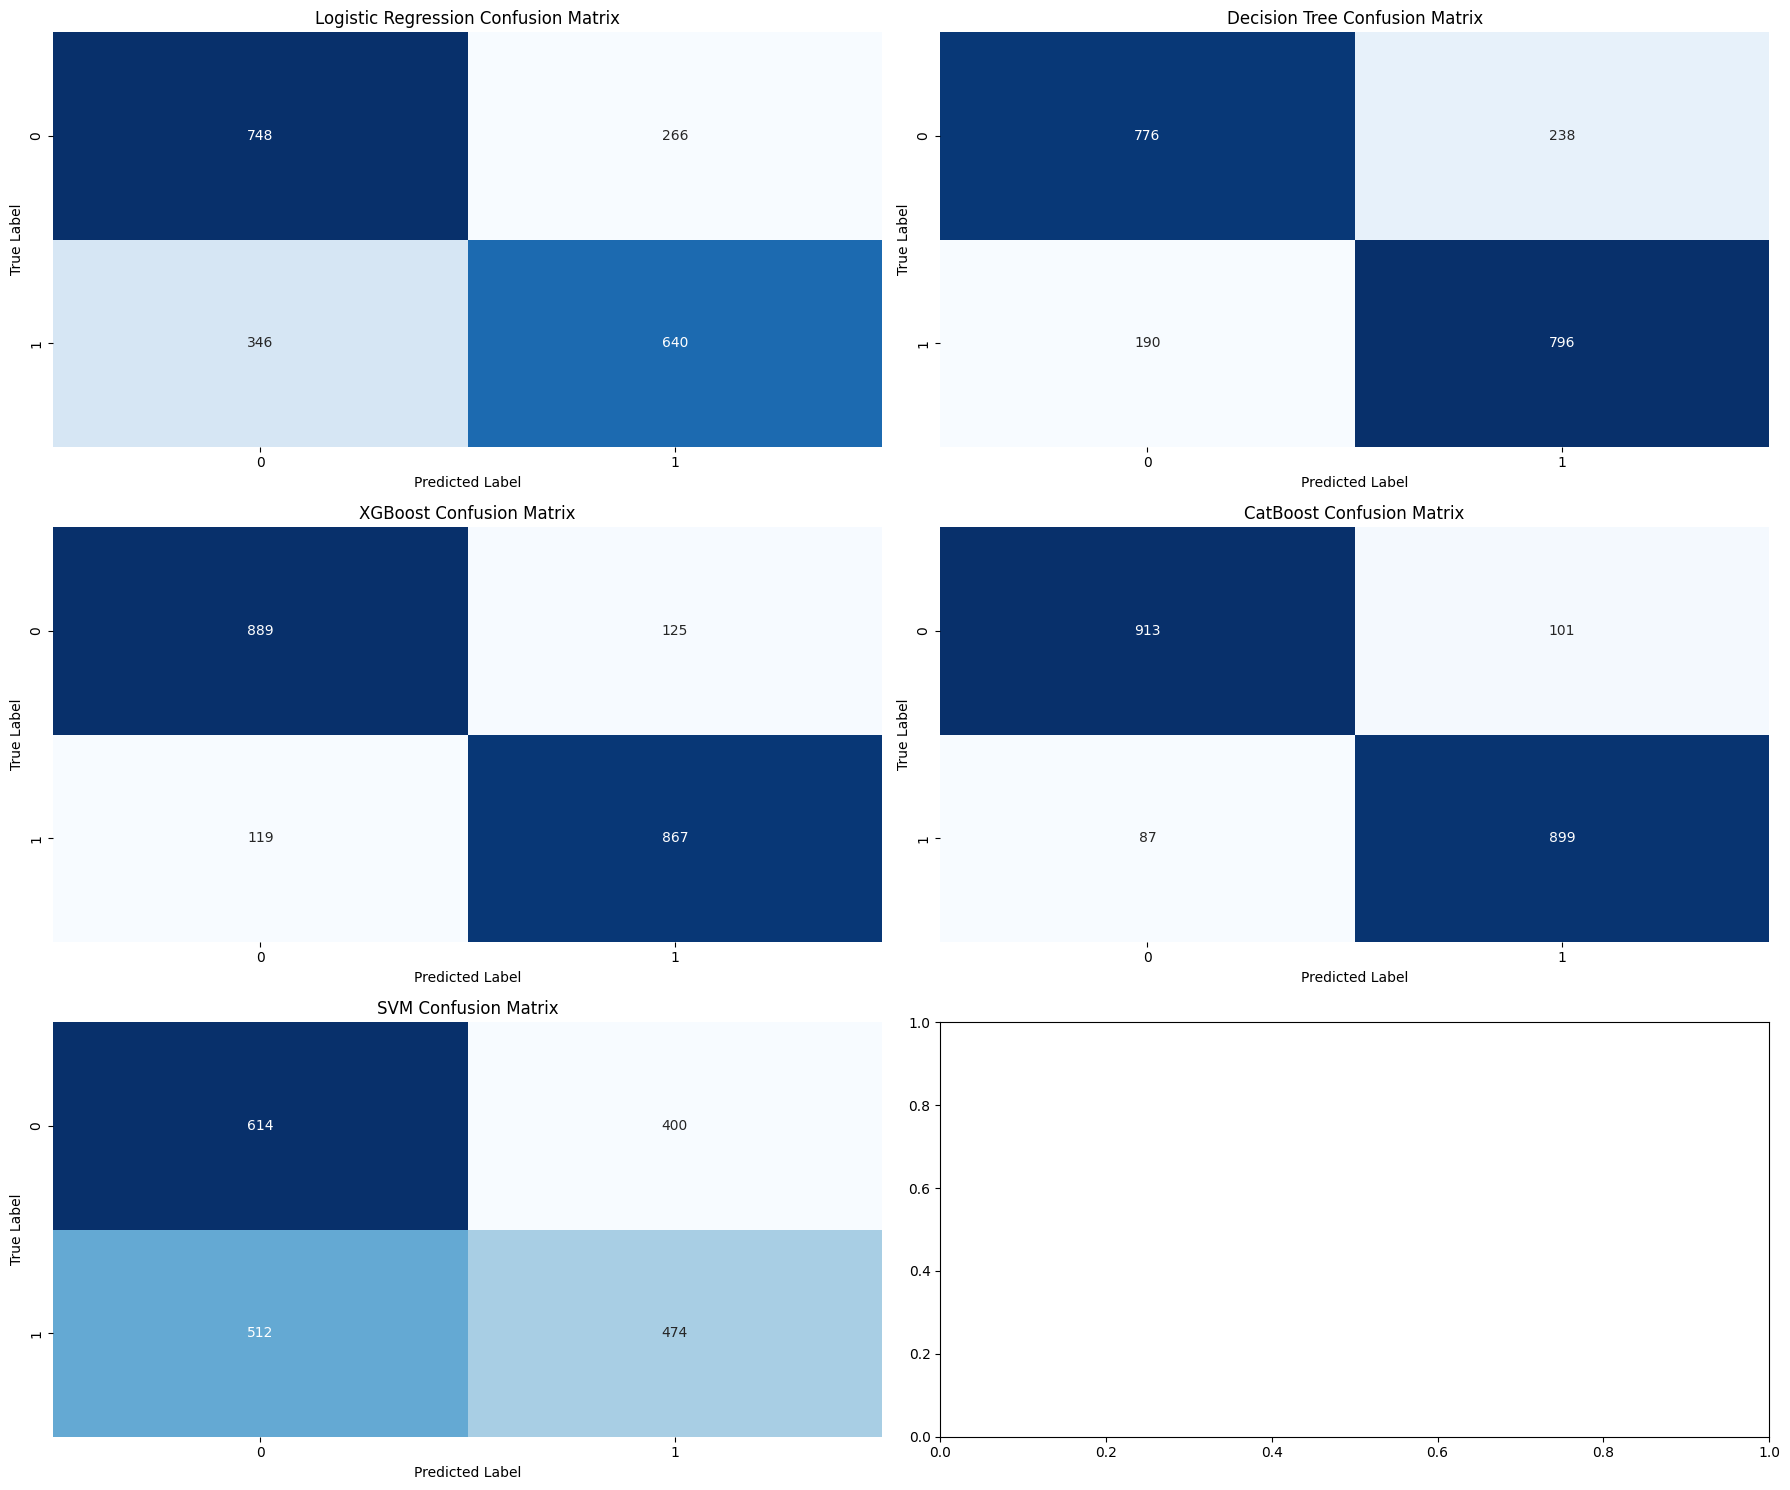

In [27]:
# Confusion matrix visualization
confusion_matrices = {
    'Logistic Regression': np.array([[748, 266], [346, 640]]),
    'Decision Tree': np.array([[776, 238], [190, 796]]),
    'XGBoost': np.array([[889, 125], [119, 867]]),
    'CatBoost': confusion_matrix(y_test, models['CatBoost'].predict(X_test)),
    'SVM': confusion_matrix(y_test, models['SVM'].predict(X_test))
}

fig, axes = plt.subplots(3, 2, figsize=(18, 15))
for ax, (model_name, cm) in zip(axes.flatten(), confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{model_name} Confusion Matrix')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
plt.tight_layout()
plt.show()

The code and the results presented analyze the model performance before and after feature engineering.

1. The code iterates through different models, computes the average accuracy before feature engineering (`cv_results`), and then evaluates each model's accuracy after feature engineering using the test set.
2. The improvement is calculated by subtracting the accuracy before feature engineering from the accuracy after.
- Logistic Regression shows a slight improvement in accuracy (from 0.6997 to 0.7030), indicating limited benefit from feature engineering.
- Decision Tree accuracy increased significantly (from 0.7571 to 0.8530), suggesting feature engineering was quite effective for this model.
-XGBoost and CatBoost models also show slight improvements, indicating effective use of the new features.
- On the other hand, SVM experienced a decline in accuracy (from 0.5553 to 0.5440), implying that feature engineering had a negative impact.

- Feature engineering was particularly beneficial for Decision Tree, while SVM's performance declined, possibly due to overfitting or incompatibility of new features with this model.

In [26]:
# Comparison Summary
print("\nModel Performance Comparison Before and After Feature Engineering:\n")
for model_name in models.keys():
    before_acc = cv_results[model_name]['mean']
    after_acc = accuracy_score(y_test, models[model_name].predict(X_test))
    improvement = after_acc - before_acc
    print(f"{model_name}: Before = {before_acc:.4f}, After = {after_acc:.4f}, Improvement = {improvement:.4f}")


Model Performance Comparison Before and After Feature Engineering:

Logistic Regression: Before = 0.6997, After = 0.7030, Improvement = 0.0033
Decision Tree: Before = 0.7571, After = 0.8530, Improvement = 0.0959
XGBoost: Before = 0.8634, After = 0.8900, Improvement = 0.0266
CatBoost: Before = 0.8912, After = 0.9060, Improvement = 0.0148
SVM: Before = 0.5553, After = 0.5440, Improvement = -0.0112
